In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn_evaluation import plot
import loadData
import pandas as pd
import numpy as np
from sklearn import tree
import graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree._tree import TREE_LEAF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# load data
adult_training_set, adult_testing_set = loadData.loadDataWithTestSet('adult.data', 'adult.test')
# preprocess data
# training set
adult_training_set_labels = adult_training_set.iloc[:,-1]
adult_training_set = adult_training_set.iloc[:,0:-1]
adult_training_set_labels[adult_training_set_labels.str.contains('>50K',na=False)] = 1
adult_training_set_labels[adult_training_set_labels.str.contains('<=50K',na=False)] = 0
adult_training_set_labels = adult_training_set_labels.astype('int')
# testing set
adult_testing_set_labels = adult_testing_set.iloc[:,-1]
adult_testing_set = adult_testing_set.iloc[:,0:-1]
adult_testing_set_labels[adult_testing_set_labels.str.contains('>50K',na=False)] = 1
adult_testing_set_labels[adult_testing_set_labels.str.contains('<=50K',na=False)] = 0
adult_testing_set_labels = adult_testing_set_labels.astype('int')

processed_adult_training_set = pd.get_dummies(adult_training_set, columns=['workclass','education','marital-status','occupation','relationship',
                                           'race','sex','native-country'])
processed_adult_testing_set = pd.get_dummies(adult_testing_set, columns=['workclass','education','marital-status','occupation','relationship',
                                           'race','sex','native-country'])
print(processed_adult_training_set.columns[~processed_adult_training_set.columns.isin(processed_adult_testing_set.columns)])
missing_column = np.zeros(16281)
missing_column = pd.DataFrame(missing_column, columns=['native-country_Holand-Netherlands'])
processed_adult_testing_set = pd.concat([processed_adult_testing_set,missing_column], axis=1)

Index(['native-country_Holand-Netherlands'], dtype='object')


In [9]:
# decision tree
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(processed_adult_training_set, adult_training_set_labels)

def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are shildren, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)

training_set_acc_DT = []
testing_set_acc_DT = []
thresholds = range(0, 500, 10)
for x in thresholds:
    prune_index(dtc.tree_, 0, x)
    predicted_training_set_labels = dtc.predict(processed_adult_training_set)
    predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
    training_set_acc_DT.append(accuracy_score(adult_training_set_labels, predicted_training_set_labels))
    
    predicted_testing_set_labels = dtc.predict(processed_adult_testing_set)
    predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
    testing_set_acc_DT.append(accuracy_score(adult_testing_set_labels, predicted_testing_set_labels))
print(training_set_acc_DT)
print(testing_set_acc_DT)


[0.9999692884125181, 0.9104450109026135, 0.8926937133380425, 0.8848315469426614, 0.880900463744971, 0.877982862934185, 0.874512453548724, 0.8729154509996622, 0.8719019686127576, 0.8692914836767912, 0.8689536562144897, 0.8681244433524768, 0.8671109609655723, 0.8667731335032708, 0.8656368047664383, 0.8652375541291729, 0.8649304382543533, 0.8649304382543533, 0.8635177052301833, 0.8633948588802555, 0.8633948588802555, 0.8633948588802555, 0.8627499155431344, 0.8627499155431344, 0.8624427996683148, 0.8620742606185313, 0.8613986056939283, 0.8613986056939283, 0.8613986056939283, 0.8613986056939283, 0.8600780074322042, 0.8600780074322042, 0.8600780074322042, 0.8600780074322042, 0.8596480452074567, 0.8596480452074567, 0.8596480452074567, 0.8596480452074567, 0.8591259482202636, 0.85875740917048, 0.8584810048831424, 0.8584810048831424, 0.8584810048831424, 0.8584810048831424, 0.8584810048831424, 0.8584810048831424, 0.8584810048831424, 0.8584810048831424, 0.8584810048831424, 0.8584810048831424]
[0.8

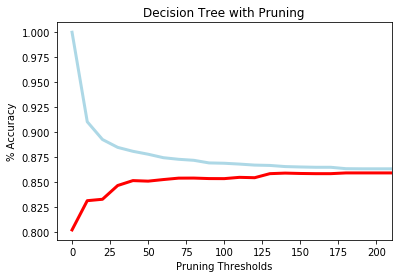

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(thresholds, training_set_acc_DT, color='lightblue', linewidth=3, label='Training Set Accuracy')
ax.plot(thresholds, testing_set_acc_DT, color='red', linewidth=3, label='Testing Set Accuracy')
ax.set_xlim(-10, 210)
ax.set(title='Decision Tree with Pruning',
 ylabel='% Accuracy', xlabel='Pruning Thresholds')
plt.savefig('DT1.png')
plt.show()

In [11]:
# graph decision tree as png
dot_data = tree.export_graphviz(dtc, out_file='tree1.dot', feature_names=processed_adult_training_set.columns, 
                                filled=True, rounded=True)  
graph = graphviz.Source(dot_data)
from subprocess import check_call
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

0

In [3]:
# neural networks
nn = MLPClassifier(activation='logistic', solver='sgd')
nn.fit(processed_adult_training_set, adult_training_set_labels)

predicted_training_set_labels = nn.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = nn.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

0.7591904425539756
0.7637737239727289


In [18]:
alphas = [0.0001, 0.0002, 0.0005, 0.0007, 0.001, 0.002, 0.005, 0.01]
learning_rates = [0.001, 0.002, 0.005, 0.007, 0.01]
momentums = [0.9, 0.85, 0.8, 0.75, 0.7]
param_grid = dict(alpha=alphas, learning_rate_init = learning_rates, momentum = momentums)
grid_nn = GridSearchCV(estimator=nn, param_grid=param_grid)
grid_result_nn = grid_nn.fit(processed_adult_training_set, adult_training_set_labels)


print("Best: %f using %s" % (grid_result_nn.best_score_, grid_result_nn.best_params_))
means = grid_result_nn.cv_results_['mean_test_score']
stds = grid_result_nn.cv_results_['std_test_score']
params = grid_result_nn.cv_results_['params']
results = zip(means, stds, params)
for mean, stdev, param in sorted(results, key=lambda x: x[0], reverse=True):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

predicted_training_set_labels = grid_nn.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc_nn=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = grid_nn.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc_nn=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc_nn)
print(testing_set_acc_nn)

Best: 0.762845 using {'alpha': 0.005, 'learning_rate_init': 0.007, 'momentum': 0.9}
0.762845 (0.001790) with: {'alpha': 0.005, 'learning_rate_init': 0.007, 'momentum': 0.9}
0.762722 (0.000639) with: {'alpha': 0.0002, 'learning_rate_init': 0.01, 'momentum': 0.75}
0.762415 (0.002555) with: {'alpha': 0.0007, 'learning_rate_init': 0.01, 'momentum': 0.9}
0.762262 (0.001905) with: {'alpha': 0.0001, 'learning_rate_init': 0.007, 'momentum': 0.9}
0.762231 (0.001041) with: {'alpha': 0.01, 'learning_rate_init': 0.01, 'momentum': 0.85}
0.762108 (0.001430) with: {'alpha': 0.001, 'learning_rate_init': 0.005, 'momentum': 0.9}
0.761893 (0.000490) with: {'alpha': 0.005, 'learning_rate_init': 0.01, 'momentum': 0.9}
0.761801 (0.000729) with: {'alpha': 0.0005, 'learning_rate_init': 0.007, 'momentum': 0.85}
0.761801 (0.001387) with: {'alpha': 0.0007, 'learning_rate_init': 0.01, 'momentum': 0.85}
0.761801 (0.001266) with: {'alpha': 0.01, 'learning_rate_init': 0.005, 'momentum': 0.9}
0.761770 (0.001885) with

0.7612174073277848
0.7665376819605675


c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


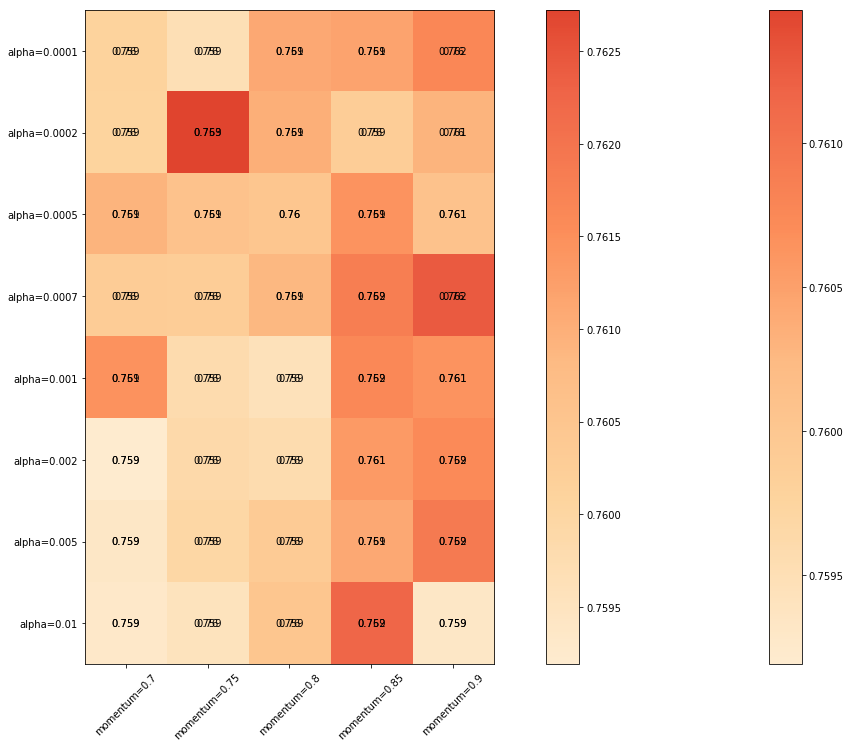

In [19]:
ax = plot.grid_search(grid_nn.grid_scores_, change=('alpha', 'learning_rate_init'),
              subset={'momentum': 0.7})
fig = ax.get_figure()
fig.set_size_inches(18.5, 10.5)
fig.savefig('NN1.png')
fig.clf()
ax = plot.grid_search(grid_nn.grid_scores_, change=('alpha', 'momentum'),
              subset={'learning_rate_init': 0.01})
fig = ax.get_figure()
fig.savefig('NN2.png')
fig.clf()

In [20]:
# boosting
gbc = GradientBoostingClassifier()
gbc.fit(processed_adult_training_set, adult_training_set_labels)

predicted_training_set_labels = gbc.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = gbc.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

0.8690457909769356
0.8693569191081629


In [24]:
nEstimators = [100, 300, 500, 700, 900]
learning_rates = [0.1, 0.3, 0.5, 0.7, 1.0]
param_grid = dict(learning_rate = learning_rates, n_estimators = nEstimators)
grid_b = GridSearchCV(estimator=gbc, param_grid=param_grid)
grid_result_b = grid_b.fit(processed_adult_training_set, adult_training_set_labels)


print("Best: %f using %s" % (grid_result_b.best_score_, grid_result_b.best_params_))
means = grid_result_b.cv_results_['mean_test_score']
stds = grid_result_b.cv_results_['std_test_score']
params = grid_result_b.cv_results_['params']
results = zip(means, stds, params)
for mean, stdev, param in sorted(results, key=lambda x: x[0], reverse=True):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

predicted_training_set_labels = grid_b.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = grid_b.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

Best: 0.872209 using {'learning_rate': 0.1, 'n_estimators': 500}
0.872209 (0.002673) with: {'learning_rate': 0.1, 'n_estimators': 500}
0.871656 (0.002902) with: {'learning_rate': 0.1, 'n_estimators': 700}
0.871503 (0.003652) with: {'learning_rate': 0.1, 'n_estimators': 300}
0.870428 (0.003237) with: {'learning_rate': 0.1, 'n_estimators': 900}
0.869936 (0.003279) with: {'learning_rate': 0.3, 'n_estimators': 100}
0.869291 (0.002102) with: {'learning_rate': 0.3, 'n_estimators': 300}
0.869230 (0.002479) with: {'learning_rate': 0.5, 'n_estimators': 100}
0.867357 (0.004121) with: {'learning_rate': 0.7, 'n_estimators': 100}
0.865760 (0.003197) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.864838 (0.002192) with: {'learning_rate': 0.3, 'n_estimators': 500}
0.864470 (0.004527) with: {'learning_rate': 1.0, 'n_estimators': 100}
0.863641 (0.001280) with: {'learning_rate': 0.5, 'n_estimators': 300}
0.863272 (0.002472) with: {'learning_rate': 0.3, 'n_estimators': 700}
0.862320 (0.002258) with:

In [26]:
ax = plot.grid_search(grid_b.grid_scores_, change=('learning_rate', 'n_estimators'))
fig = ax.get_figure()
fig.set_size_inches(18.5, 10.5)
fig.savefig('boosting1.png')
fig.clf()

c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


<Figure size 1332x756 with 0 Axes>

In [38]:
nEstimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
learning_rate=[0.1]
param_grid = dict(n_estimators = nEstimators, learning_rate=learning_rate)
grid_b2 = GridSearchCV(estimator=gbc, param_grid=param_grid)
grid_result_b2 = grid_b2.fit(processed_adult_training_set, adult_training_set_labels)


print("Best: %f using %s" % (grid_result_b2.best_score_, grid_result_b2.best_params_))
means = grid_result_b2.cv_results_['mean_test_score']
stds = grid_result_b2.cv_results_['std_test_score']
params = grid_result_b2.cv_results_['params']
results = zip(means, stds, params)
for mean, stdev, param in sorted(results, key=lambda x: x[0], reverse=True):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

predicted_training_set_labels = grid_b2.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = grid_b2.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

Best: 0.872178 using {'learning_rate': 0.1, 'n_estimators': 500}
0.872178 (0.002601) with: {'learning_rate': 0.1, 'n_estimators': 500}
0.872117 (0.002835) with: {'learning_rate': 0.1, 'n_estimators': 400}
0.871994 (0.002555) with: {'learning_rate': 0.1, 'n_estimators': 600}
0.871564 (0.003574) with: {'learning_rate': 0.1, 'n_estimators': 300}
0.871564 (0.002902) with: {'learning_rate': 0.1, 'n_estimators': 700}
0.870796 (0.003220) with: {'learning_rate': 0.1, 'n_estimators': 800}
0.870551 (0.003233) with: {'learning_rate': 0.1, 'n_estimators': 900}
0.869783 (0.002450) with: {'learning_rate': 0.1, 'n_estimators': 1000}
0.868862 (0.003456) with: {'learning_rate': 0.1, 'n_estimators': 200}
0.865668 (0.003271) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.8866742421915789
0.8603894109698421


In [39]:
print(grid_b2.grid_scores_)
ax = plot.grid_search(grid_b2.grid_scores_, change='n_estimators')
fig = ax.get_figure()
fig.savefig('boosting2.png')
fig.set_size_inches(18.5, 10.5)
fig.clf()

[mean: 0.86567, std: 0.00327, params: {'learning_rate': 0.1, 'n_estimators': 100}, mean: 0.86886, std: 0.00346, params: {'learning_rate': 0.1, 'n_estimators': 200}, mean: 0.87156, std: 0.00357, params: {'learning_rate': 0.1, 'n_estimators': 300}, mean: 0.87212, std: 0.00283, params: {'learning_rate': 0.1, 'n_estimators': 400}, mean: 0.87218, std: 0.00260, params: {'learning_rate': 0.1, 'n_estimators': 500}, mean: 0.87199, std: 0.00255, params: {'learning_rate': 0.1, 'n_estimators': 600}, mean: 0.87156, std: 0.00290, params: {'learning_rate': 0.1, 'n_estimators': 700}, mean: 0.87080, std: 0.00322, params: {'learning_rate': 0.1, 'n_estimators': 800}, mean: 0.87055, std: 0.00323, params: {'learning_rate': 0.1, 'n_estimators': 900}, mean: 0.86978, std: 0.00245, params: {'learning_rate': 0.1, 'n_estimators': 1000}]


c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


<Figure size 1332x756 with 0 Axes>

In [40]:
maxDepths = [3, 4, 5, 6, 7]
learning_rate=[0.1]
param_grid = dict(max_depth = maxDepths, learning_rate=learning_rate)
grid_b3 = GridSearchCV(estimator=gbc, param_grid=param_grid)
grid_result_b3 = grid_b3.fit(processed_adult_training_set, adult_training_set_labels)


print("Best: %f using %s" % (grid_result_b3.best_score_, grid_result_b3.best_params_))
means = grid_result_b3.cv_results_['mean_test_score']
stds = grid_result_b3.cv_results_['std_test_score']
params = grid_result_b3.cv_results_['params']
results = zip(means, stds, params)
for mean, stdev, param in sorted(results, key=lambda x: x[0], reverse=True):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

predicted_training_set_labels = grid_b3.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = grid_b3.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

Best: 0.872578 using {'learning_rate': 0.1, 'max_depth': 6}
0.872578 (0.002997) with: {'learning_rate': 0.1, 'max_depth': 6}
0.871226 (0.003513) with: {'learning_rate': 0.1, 'max_depth': 5}
0.869599 (0.002499) with: {'learning_rate': 0.1, 'max_depth': 7}
0.868800 (0.003059) with: {'learning_rate': 0.1, 'max_depth': 4}
0.865729 (0.003204) with: {'learning_rate': 0.1, 'max_depth': 3}
0.8916802309511379
0.8745163073521283


In [42]:
ax = plot.grid_search(grid_b3.grid_scores_, change=('max_depth'))
fig = ax.get_figure()
fig.set_size_inches(18.5, 10.5)
fig.savefig('boosting3.png')
fig.clf()

c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


<Figure size 1332x756 with 0 Axes>

In [4]:
# KNN
knn = KNeighborsClassifier()
knn.fit(processed_adult_training_set, adult_training_set_labels)

predicted_training_set_labels = knn.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = knn.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

0.8357851417339762
0.7769793010257355


In [ ]:
n_neighbors = [5, 6, 7, 8, 9, 10]
weights = ["uniform", "distance"]
p = [1, 2, 3, 4]
param_grid = dict(n_neighbors = n_neighbors, weights = weights, p = p)
grid_knn = GridSearchCV(estimator=knn, param_grid=param_grid)
grid_result_knn = grid_knn.fit(processed_adult_training_set, adult_training_set_labels)


print("Best: %f using %s" % (grid_result_knn.best_score_, grid_result_knn.best_params_))
means = grid_result_knn.cv_results_['mean_test_score']
stds = grid_result_knn.cv_results_['std_test_score']
params = grid_result_knn.cv_results_['params']
results = zip(means, stds, params)
for mean, stdev, param in sorted(results, key=lambda x: x[0], reverse=True):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

predicted_training_set_labels = grid_knn.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = grid_knn.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

In [ ]:
ax = plot.grid_search(grid_knn.grid_scores_, change=('n_neighbors', 'p'), subset={'weights': 'uniform'})
fig = ax.get_figure()
fig.set_size_inches(18.5, 10.5)
fig.savefig('knn1.png')
fig.clf()
ax = plot.grid_search(grid_knn.grid_scores_, change=('n_neighbors', 'p'), subset={'weights': 'distance'})
fig = ax.get_figure()
fig.set_size_inches(18.5, 10.5)
fig.savefig('knn2.png')
fig.clf()

In [7]:
n_neighbors = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
weights = ["uniform"]
param_grid = dict(n_neighbors = n_neighbors, weights = weights)
grid_knn = GridSearchCV(estimator=knn, param_grid=param_grid)
grid_result_knn = grid_knn.fit(processed_adult_training_set, adult_training_set_labels)


print("Best: %f using %s" % (grid_result_knn.best_score_, grid_result_knn.best_params_))
means = grid_result_knn.cv_results_['mean_test_score']
stds = grid_result_knn.cv_results_['std_test_score']
params = grid_result_knn.cv_results_['params']
results = zip(means, stds, params)
for mean, stdev, param in sorted(results, key=lambda x: x[0], reverse=True):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

predicted_training_set_labels = grid_knn.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = grid_knn.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

Best: 0.797948 using {'n_neighbors': 25, 'weights': 'uniform'}
0.797948 (0.000860) with: {'n_neighbors': 25, 'weights': 'uniform'}
0.797211 (0.001160) with: {'n_neighbors': 20, 'weights': 'uniform'}
0.797150 (0.001191) with: {'n_neighbors': 30, 'weights': 'uniform'}
0.796843 (0.001150) with: {'n_neighbors': 15, 'weights': 'uniform'}
0.796444 (0.001430) with: {'n_neighbors': 35, 'weights': 'uniform'}
0.795399 (0.000319) with: {'n_neighbors': 10, 'weights': 'uniform'}
0.795399 (0.000758) with: {'n_neighbors': 40, 'weights': 'uniform'}
0.794816 (0.000942) with: {'n_neighbors': 45, 'weights': 'uniform'}
0.793864 (0.000865) with: {'n_neighbors': 50, 'weights': 'uniform'}
0.775529 (0.001995) with: {'n_neighbors': 5, 'weights': 'uniform'}
0.8036608212278493
0.8027148209569437


In [8]:
ax = plot.grid_search(grid_knn.grid_scores_, change=('n_neighbors'))
fig = ax.get_figure()
fig.set_size_inches(18.5, 10.5)
fig.savefig('knn3.png')
fig.clf()

c:\users\tommy\.virtualenvs\assignment1-ocs3pq-h\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


<Figure size 1332x756 with 0 Axes>

In [9]:
# SVM
svm = svm.SVC()
svm.fit(processed_adult_training_set, adult_training_set_labels)

predicted_training_set_labels = svm.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = svm.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

0.9603206289733116
0.7604569743873226


In [ ]:
kernels = ['linear', 'poly', 'rbf']
C=[1.0]
param_grid = dict(kernel = kernels, C=C)
grid = GridSearchCV(estimator=svm, param_grid=param_grid)
grid_result = grid.fit(processed_adult_training_set, adult_training_set_labels)


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
results = zip(means, stds, params)
for mean, stdev, param in sorted(results, key=lambda x: x[0], reverse=True):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

predicted_training_set_labels = grid.predict(processed_adult_training_set)
predicted_training_set_labels = pd.DataFrame(predicted_training_set_labels) 
training_set_acc=accuracy_score(adult_training_set_labels, predicted_training_set_labels)

predicted_testing_set_labels = grid.predict(processed_adult_testing_set)
predicted_testing_set_labels = pd.DataFrame(predicted_testing_set_labels)
testing_set_acc=accuracy_score(adult_testing_set_labels, predicted_testing_set_labels)

print(training_set_acc)
print(testing_set_acc)

In [ ]:
ax = plot.grid_search(grid_knn.grid_scores_, change=(kernels), subset={'C': 1.0})
fig = ax.get_figure()
fig.set_size_inches(18.5, 10.5)
fig.savefig('svm1.png')
fig.clf()